<a href="https://colab.research.google.com/github/yotamraz/wsc-classifier/blob/main/wsc_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **General approach**

1. EDA
2. training
3. testing
4. analysis and improvment suggestions
5. retrain
6. testing

# **Notebook init**

In [1]:
# installing additional packages
!pip install wandb
!wandb login
!git config --global user.email "yotamraz2007@gmail.com"
!pip install gdown
!pip install imbalanced-learn

     |████████████████████████████████| 1.7 MB 9.3 MB/s 
     |████████████████████████████████| 181 kB 69.8 MB/s 
     |████████████████████████████████| 144 kB 71.7 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=d8da2ff3535cdaaaf051a8f9393984e2a6adb22414e8ad264eb04d0dca84131c
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# NO NEED TO RUN THIS CELL, checking general hardware stats
!nvidia-smi
!cat /proc/cpuinfo
!cat /proc/meminfo

In [2]:
import wandb
import os
import shutil
import random
import string
from PIL import Image, ImageStat
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pytz import timezone
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from wandb.keras import WandbCallback
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers
from sklearn.metrics import classification_report

In [35]:
# clone to repo to retrive dataset
!git clone https://github.com/yotamraz/wsc-classifier.git
!mv ./wsc-classifier/wsc_dataset.zip ./
# unzip dataset
!mkdir wsc_dataset
!unzip wsc_dataset.zip -d wsc_dataset

# general parameters
sns.set_theme(style="darkgrid")
wandb_project_name = "wsc-classifier"
time_stamp = datetime.datetime.now(tz=timezone("Israel")).strftime("%d-%m-%Y-%H:%M:%S")
dataset_url = "https://drive.google.com/uc?id=122_EJbCsnrAowFTfFV1AmkIeyoAVb-QH"
dataset_dir = "/content/wsc_dataset/"
checkpoints_dir = "/content/checkpoints/"

#preprocessing parameters
image_size = (224, 224)
batch_size = 16
class_list = ["angle", "box", "circle", "closeup", "crowd", "other"]

fatal: destination path 'wsc-classifier' already exists and is not an empty directory.
mv: cannot stat './wsc-classifier/wsc_dataset.zip': No such file or directory
Archive:  wsc_dataset.zip
  inflating: wsc_dataset/readme.md   
   creating: wsc_dataset/test/
   creating: wsc_dataset/test/Angle/
  inflating: wsc_dataset/test/Angle/20181121-140024_200.jpg  
  inflating: wsc_dataset/test/Angle/20190310-140201_18_1080.jpg  
  inflating: wsc_dataset/test/Angle/20190310-140259_22_288.jpg  
  inflating: wsc_dataset/test/Angle/20190310-140416_26_384.jpg  
  inflating: wsc_dataset/test/Angle/20190310-140920_43_672.jpg  
  inflating: wsc_dataset/test/Angle/20190310-141318_57_516.jpg  
  inflating: wsc_dataset/test/Angle/20190310-142520_98_444.jpg  
  inflating: wsc_dataset/test/Angle/20190310-142759_107_348.jpg  
  inflating: wsc_dataset/test/Angle/20190310-142911_111_684.jpg  
  inflating: wsc_dataset/test/Angle/4BA51BAE-0B08-4A64-891F-137E1DB14EC2_frame_24.jpg  
   creating: wsc_dataset/test/

**recurrent methods**


some methods are used multiple times, so implementing them once is more efficient and clean

In [36]:
def dir_to_df() -> pd.DataFrame:
  df_columns = ["image_path", "class_name", "group", "image_width", "image_height", "resolution", "R_min_max", "R_std", "G_min_max", "G_std", "B_min_max", "B_std"]
  agg_list = []
  # go over dataset directory
  for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith(".jpg"):
          image_path = os.path.join(root, file)
          try:
            image = Image.open(image_path)
          except FileNotFoundError as err:
            print(f"cannot open image file: {image_path}")
            continue
          class_name = root.split("/")[-1].lower()
          group = root.split("/")[-2].lower()
          width, height = image.size
          resolution = (width*height) / 1e6
          stats = ImageStat.Stat(image)
          R_min_max = stats.extrema[0]
          R_std = stats.stddev[0]
          G_min_max = stats.extrema[1]
          G_std = stats.stddev[1]
          B_min_max = stats.extrema[2]
          B_std = stats.stddev[2]
          agg_list.append([image_path, class_name, group, width, height, resolution, R_min_max, R_std, G_min_max, G_std, B_min_max, B_std])
  return pd.DataFrame(data=agg_list, columns=df_columns)

def create_generators():
  # validation subset sized as one batch
  train_datagen = ImageDataGenerator(
    rotation_range=10, 
    width_shift_range=0.1,
    height_shift_range=0.1, 
    brightness_range=[0.98, 1.02], 
    shear_range=0.05, 
    zoom_range=0.1,
    channel_shift_range=0.05,
    horizontal_flip=True, 
    rescale=1./255,
    validation_split=0.1
  )

  test_datagen = ImageDataGenerator(rescale=1./255)

  train_generator = train_datagen.flow_from_directory(
      f"{dataset_dir}/train",
      target_size=image_size,
      batch_size=batch_size,
      class_mode='categorical',
      seed=42,
      subset="training")

  validation_generator = train_datagen.flow_from_directory(
      f"{dataset_dir}/train",
      target_size=image_size,
      batch_size=batch_size,
      class_mode='categorical',
      seed=42,
      subset="validation")

  test_generator = test_datagen.flow_from_directory(
      f"{dataset_dir}/test",
      target_size=image_size,
      batch_size=batch_size,
      class_mode='categorical',
      seed=42)
  
  return train_generator, validation_generator, test_generator

# efficientnet model without pretraining
def build_efficientnet(num_classes: int, dropout: float = 0.2) -> tf.keras.Model:
  inputs = layers.Input(shape=(image_size[0], image_size[1], 3))
  outputs = EfficientNetB0(include_top=True, weights=None, classes=num_classes, drop_connect_rate=dropout)(inputs)
  model = tf.keras.Model(inputs, outputs)
  return model

# efficientnet model pretrained on "imagenet"
def build_efficientnet_pretrained(num_classes: int, dropout: float=0.2, is_trainable: bool=True) -> tf.keras.Model:
  inputs = layers.Input(shape=(image_size[0], image_size[1], 3))
  effnet = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet", drop_connect_rate=dropout)

  # freeze pretrained body
  effnet.trainable = is_trainable

  #build top
  x = layers.GlobalAveragePooling2D(name="avg_pool")(effnet.output)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(dropout, name="top_dropout")(x)
  outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)
  
  model = tf.keras.Model(inputs, outputs, name="EfficientNetB0")
  return model

def model_eval(model, wandb_client, overall: bool=True, per_class: bool=True) -> None:
  if overall:
    # model evaluation
    test_loss, test_accuracy = model.evaluate(test_generator, batch_size=batch_size)
    print("test loss, test acc:", [test_loss, test_accuracy])
    wandb_client.log({"test loss": test_loss, "test accuracy": test_accuracy})
  if per_class:
    from sklearn.metrics import classification_report
    # per class evaluation
    Y_test = []
    y_pred = []
    for i, batch in enumerate(test_generator):
        curr_true, curr_pred = np.argmax(batch[1], axis=1), np.argmax(model.predict(batch[0]), axis=-1) # Convert one-hot to index
        for true, pred in zip(curr_true, curr_pred):
          Y_test.append(true) 
          y_pred.append(pred)
        if i == 9:
          break
    classification_report = classification_report(Y_test, y_pred)
    print(classification_report)
    # wandb_client.log({"evaluation report per class": classification_report})


# **EDA**

explanatory data analysis, this process should point out some regularities/irregularities in the data.


In [8]:
# start wandb run
job_type = "EDA"
eda_wb_client = wandb.init(name=f"{time_stamp} EDA", project=wandb_project_name, group=f"EDA {time_stamp}", job_type=job_type, save_code=True)

wandb: Currently logged in as: yotraz (use `wandb login --relogin` to force relogin)


**Dataset Parser**

In [37]:
# load images and extract some dataset statistics
df = dir_to_df()
df.head(100)
#save as csv
df.to_csv(os.path.join(dataset_dir, "dataset_metadata.csv"))



**Create plots**

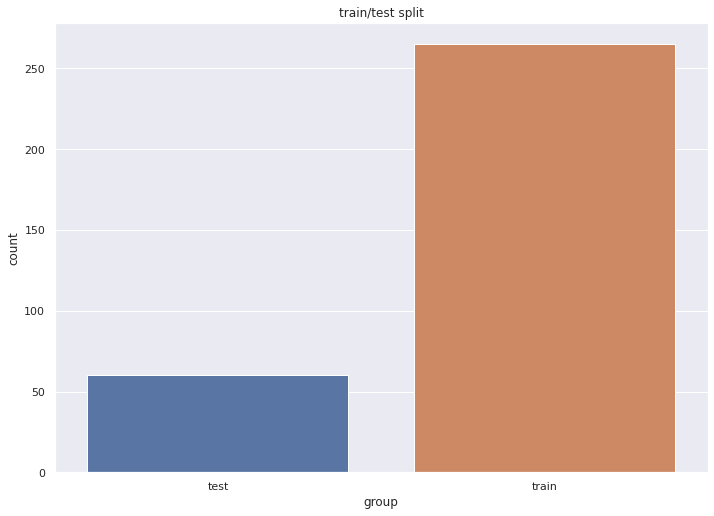

In [38]:
# train/test split
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.countplot(data=df, x="group");
title = "train/test split"
plt.title(title);


In [11]:
eda_wb_client.log({"Train/Test Split": fig})

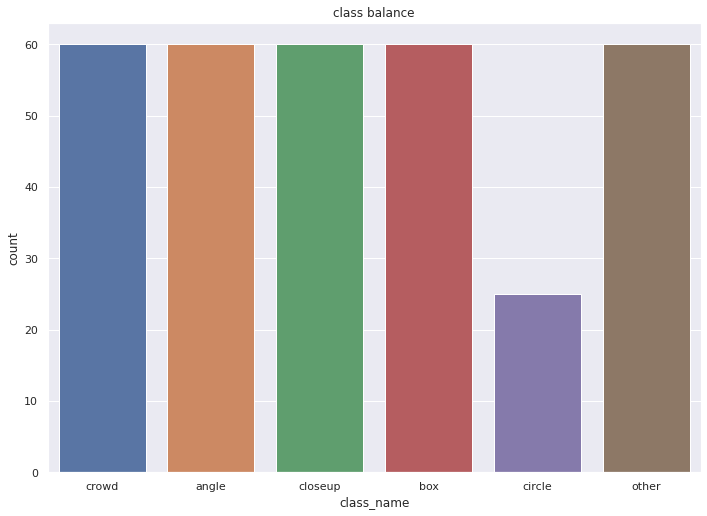

In [12]:
# class balance
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.countplot(data=df, x="class_name");
title = "class balance"
plt.title(title);


In [13]:
eda_wb_client.log({"Class Balance": fig})

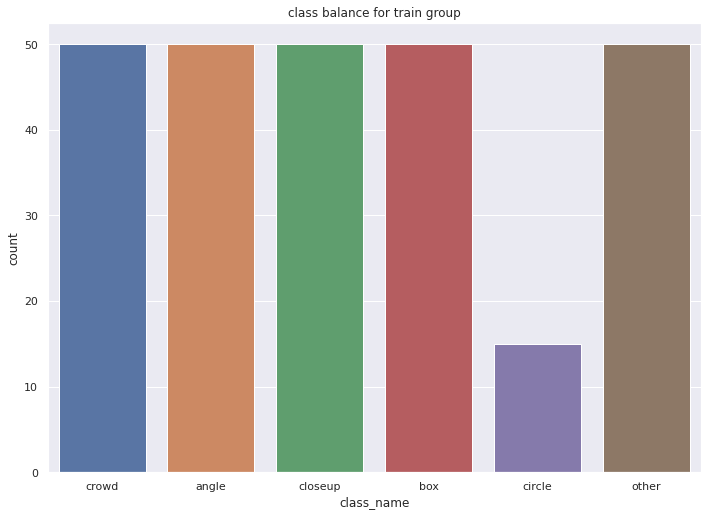

In [39]:
# class balance for train
fig_balance_train, ax = plt.subplots(figsize=(11.7, 8.27))
is_train = df["group"]=="train"
train_df = df[is_train]

sns.countplot(data=train_df, x="class_name");
title = "class balance for train group"
plt.title(title);


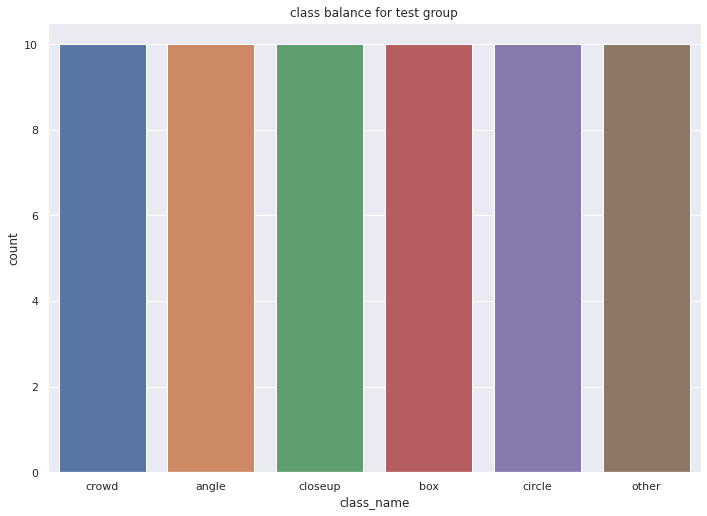

In [15]:
# class balance for test
fig_balance_test, ax = plt.subplots(figsize=(11.7, 8.27))
test_df = df[~is_train]

sns.countplot(data=test_df, x="class_name");
title = "class balance for test group"
plt.title(title);


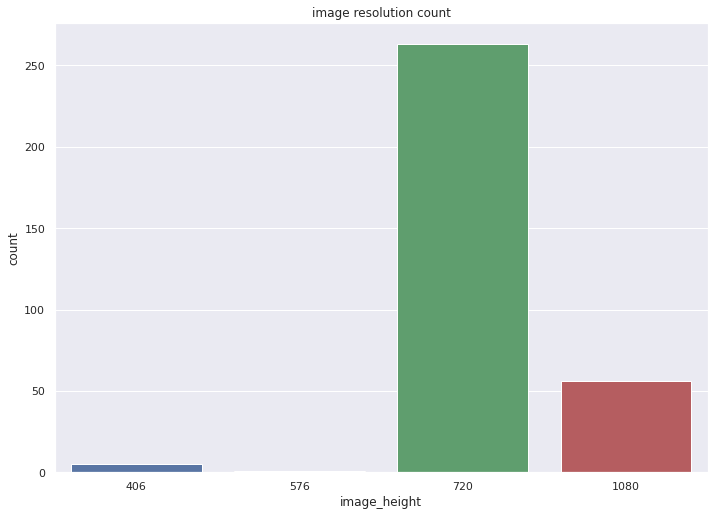

In [16]:
# image resolution
fig, ax = plt.subplots(figsize=(11.7, 8.27));
sns.countplot(data=df, x="image_height");
plt.title("image resolution count");

In [17]:
eda_wb_client.log({"Image Resolution": fig})

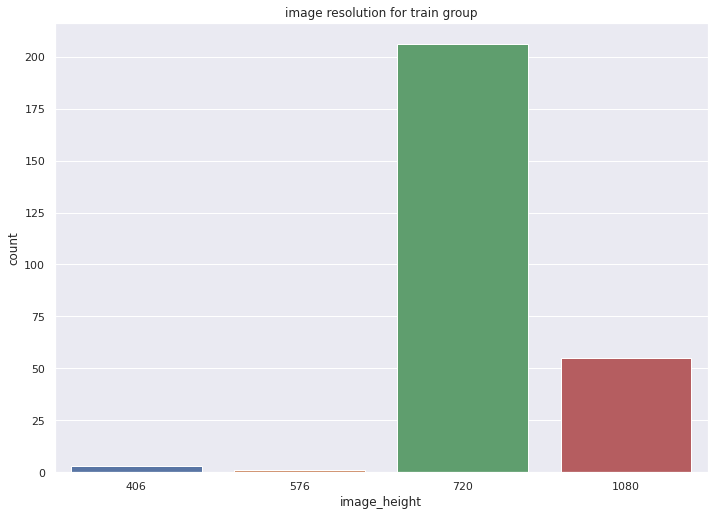

In [18]:
# image resolution for train group
fig_resolution_train, ax = plt.subplots(figsize=(11.7, 8.27))
sns.countplot(data=train_df, x="image_height");
plt.title("image resolution for train group");

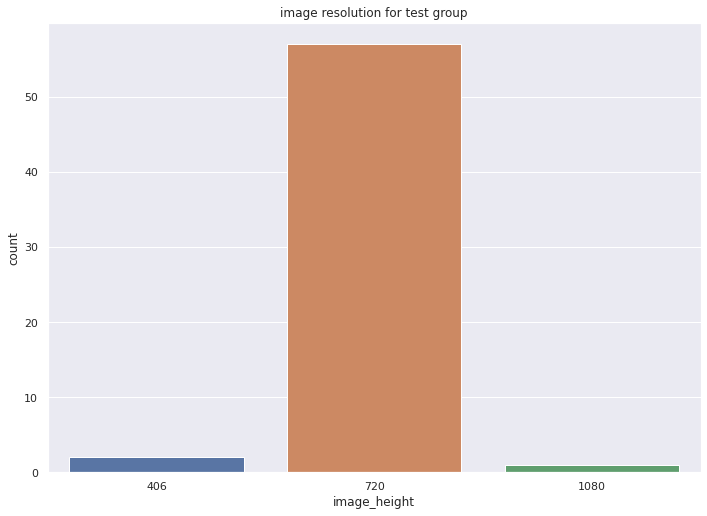

In [19]:
# image resolution for test group
fig_resolution_test, ax = plt.subplots(figsize=(11.7, 8.27));
sns.countplot(data=test_df, x="image_height");
plt.title("image resolution for test group");

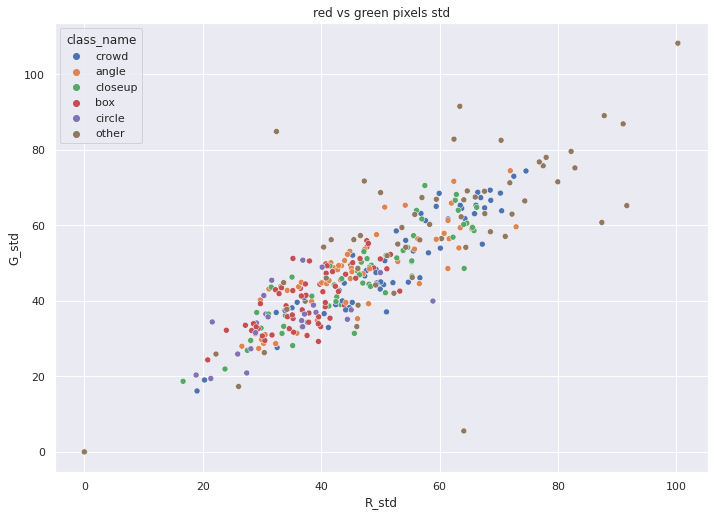

In [20]:
# red vs green pixels std
fig, ax = plt.subplots(figsize=(11.7, 8.27));
sns.scatterplot(data=df, x="R_std", y="G_std", hue="class_name");
plt.title("red vs green pixels std");

In [21]:
eda_wb_client.log({"Red vs. Green pixels std": fig})

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:575: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



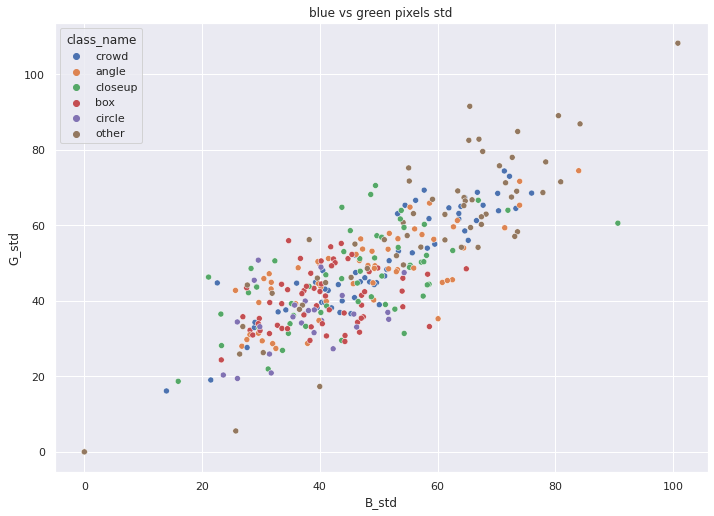

In [22]:
# blue vs green pixels std
fig_blue_green, ax = plt.subplots(figsize=(11.7, 8.27));
sns.scatterplot(data=df, x="B_std", y="G_std", hue="class_name");
plt.title("blue vs green pixels std");

# Training baseline model



**Preprocessing**

data is already splitted into train/test folders so we can use "flow from directory" to fetch the next batch of images directly from the disk

In [23]:
# create image generators using flow_from_directory
train_generator, validation_generator, test_generator = create_generators()

Found 239 images belonging to 6 classes.
Found 26 images belonging to 6 classes.
Found 60 images belonging to 6 classes.


**Visualize some images**

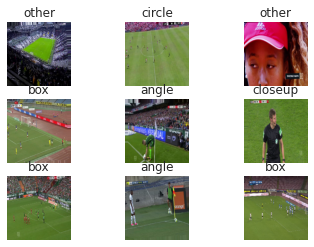

In [30]:

def format_label(label):
    class_idx = np.where(label==1.)[0][0]
    return class_list[class_idx]

for i, (image, label) in enumerate(train_generator):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0])
    plt.title("{}".format(format_label(label[0])))
    plt.axis("off")
    if i==8:
      break

**Train the model** 

In [31]:


# wandb train run
job_type = "Train"
train_wb_client = wandb.init(name=f"baseline model train", project=wandb_project_name, group=f"baseline model {time_stamp}", job_type=job_type)

# training parameters
lr = 0.010001 #@param {type:"slider", min:0.000001, max:0.2, step:0.0001}
epochs = 99 # @param {type: "slider", min:10, max:1000}
optimizer = keras.optimizers.Adam(learning_rate=lr)

# wandb callback
wandb_cb = WandbCallback()

model = build_efficientnet(len(class_list), dropout=0.2)
model.compile(
      optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
      )

model.summary()

model.fit(train_generator, validation_data=validation_generator, epochs=epochs, callbacks=[wandb_cb])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 6)                4057257   
                                                                 
Total params: 4,057,257
Trainable params: 4,015,234
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/99
15/15 [==============================] - 26s 846ms/step - loss: 10.9267 - accuracy: 0.1925 - val_loss: 2514999.0000 - val_accuracy: 0.1923
Epoch 2/99
15/15 [==============================] - 10s 680ms/step - loss: 3.2386 - accuracy: 0.2218 - val_loss: 267911.6875 - val_accuracy: 0.1923
Epoch 3/99
15/15 [==============================] - 14s 920ms/step - loss: 2.7978 - accuracy: 0.2008 - val_loss: 440.9549 - val_accuracy: 0.1923

**Evaluate model**

In [32]:
# model evaluation
job_type = "Eval"
eval_wb_client = wandb.init(name=f"baseline model eval", project=wandb_project_name,group=f"baseline model {time_stamp}", job_type=job_type)

model_eval(model, eval_wb_client, overall=True, per_class=True)

accuracy,▁▁▂▂▂▃▄▅▅▅▅▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██▇▇█▇█████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▄▇▆▇▆██▇█▆▇▇▇█▇▇▇▇▇███▅▇▇
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.91632
best_epoch,88
best_val_loss,0.8122
epoch,98
loss,0.22915
val_accuracy,0.61538


4/4 [==============================] - 1s 268ms/step - loss: 1.9659 - accuracy: 0.5333
test loss, test acc: [1.9659210443496704, 0.5333333611488342]
              precision    recall  f1-score   support

           0       0.45      0.74      0.56        27
           1       0.24      0.19      0.21        26
           2       1.00      0.19      0.32        26
           3       0.53      0.67      0.59        24
           4       0.65      1.00      0.79        26
           5       0.75      0.39      0.51        23

    accuracy                           0.53       152
   macro avg       0.60      0.53      0.50       152
weighted avg       0.60      0.53      0.50       152



# Improving the model method #1: class weights



**Train**

class weight and more dropout 

In [33]:
from wandb.keras import WandbCallback
from sklearn.utils import class_weight

# wandb train run
time_stamp = datetime.datetime.now(tz=timezone("Israel")).strftime("%d-%m-%Y-%H:%M:%S")
job_type = "Train"
train_wb_client = wandb.init(name=f"class weight train", project=wandb_project_name, group=f"class weight model {time_stamp}", job_type=job_type)

# training parameters
lr = 0.010001 #@param {type:"slider", min:0.000001, max:0.2, step:0.0001}
epochs = 99 # @param {type: "slider", min:10, max:1000}
optimizer = keras.optimizers.Adam(learning_rate=lr)

# wandb callback
wandb_cb = WandbCallback()
eraly_stopping_cb = EarlyStopping(monitor='loss', patience=15)

model = build_efficientnet(len(class_list), dropout=0.2)
model.compile(
      optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
      )
model.summary()

# loss penalties per class
my_weights = {0:1., 1:1., 2:3.33, 3:1., 4:1., 5:1.} 
hist = model.fit(train_generator, validation_data=validation_generator, epochs=epochs, class_weight=my_weights, callbacks=[wandb_cb, eraly_stopping_cb])

test accuracy,▁
test loss,▁
test accuracy,0.53333
test loss,1.96592


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 6)                4057257   
                                                                 
Total params: 4,057,257
Trainable params: 4,015,234
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/99
15/15 [==============================] - 24s 851ms/step - loss: 10.4180 - accuracy: 0.2176 - val_loss: 17371.2793 - val_accuracy: 0.1923
Epoch 2/99
15/15 [==============================] - 10s 686ms/step - loss: 2.4538 - accuracy: 0.2636 - val_loss: 763.8813 - val_accuracy: 0.1923
Epoch 3/99
15/15 [==============================] - 10s 690ms/step - loss: 2.5342 - accuracy: 0.2678 - val_loss: 67.4028 - val_accuracy: 0.1923
Epo

**Evaluate**

In [34]:
# model evaluation
job_type = "Eval"
eval_wb_client = wandb.init(name=f"class weight model eval", project=wandb_project_name,group=f"class weight model {time_stamp}", job_type=job_type)

model_eval(model, eval_wb_client, overall=True, per_class=True)

accuracy,▁▁▃▃▃▂▄▄▅▅▅▅▅▆▆▇▆▆▆▆▇▇▇▇█▇▇▇▇▇██▇██▇█▇██
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▂▂▁▁▂▂▁▂▁▁▂▁▁▁▁▄▇▇▆██▅▆▆▅▇▅▆▇▇▇▅▇▇▅▅▆▇██
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.90377
best_epoch,42
best_val_loss,0.6786
epoch,98
loss,0.27889
val_accuracy,0.73077


4/4 [==============================] - 1s 226ms/step - loss: 1.7701 - accuracy: 0.6167
test loss, test acc: [1.7700620889663696, 0.6166666746139526]
              precision    recall  f1-score   support

           0       0.59      0.74      0.65        23
           1       0.38      0.62      0.48        24
           2       1.00      0.19      0.32        26
           3       0.73      0.44      0.55        25
           4       0.90      0.76      0.83        25
           5       0.56      0.88      0.69        25

    accuracy                           0.60       148
   macro avg       0.70      0.61      0.59       148
weighted avg       0.70      0.60      0.58       148



# Improving the model method #2: oversampling

**scale up dataset with random sampling**


In [40]:
# set factor of scaling the dataset:
# number of images per class = (original number of images * scaling factor) * balance factor
scaling_factor = 6

In [41]:
# randomly select images from under-represented class directory re-save them as new image

class_names = train_df["class_name"].unique()
# compute how many images are currently available per class
count_per_class = train_df["class_name"].value_counts()
# compute the target number of images 
target_count_per_class = round((train_df["class_name"].count() * scaling_factor) / train_df["class_name"].unique().size)
# compute how many additional images should be created
target_add_per_class = target_count_per_class - count_per_class

# iterate over random images and save a copy of them back to disk
for class_name in class_names:
  for i in range(target_add_per_class[class_name]):
    random_row = train_df[train_df["class_name"] == class_name].sample(1)
    random_image_path = random_row["image_path"].values[0]
    shutil.copyfile(random_image_path, random_image_path.replace(".jpg", "".join(random.choices(string.ascii_uppercase + string.digits, k=scaling_factor)))+".jpg")



**check new class balance**

In [42]:

df = dir_to_df()
df.head(100)
# save as csv
df.to_csv(os.path.join(dataset_dir, "dataset_oversampled_metadata.csv"))
# allocate train df
train_df = df[df["group"] == "train"]

In [43]:
train_df

,image_path,class_name,group,image_width,image_height,resolution,R_min_max,R_std,G_min_max,G_std,B_min_max,B_std
60,/content/wsc_dataset/train/Crowd/20181121-1438...,crowd,train,1280,720,0.9216,"(0, 255)",56.690071,"(0, 255)",46.115820,"(0, 255)",47.641868
61,/content/wsc_dataset/train/Crowd/6ce83bbc-453c...,crowd,train,1280,720,0.9216,"(0, 255)",65.919089,"(0, 255)",63.081718,"(0, 255)",53.206554
62,/content/wsc_dataset/train/Crowd/15fdddc0-ddd8...,crowd,train,1280,720,0.9216,"(0, 255)",42.459222,"(0, 255)",38.974326,"(0, 255)",50.096495
63,/content/wsc_dataset/train/Crowd/20181125-1451...,crowd,train,1280,720,0.9216,"(0, 254)",54.287997,"(0, 253)",56.024989,"(0, 255)",65.204141
64,/content/wsc_dataset/train/Crowd/20181125-1451...,crowd,train,1280,720,0.9216,"(0, 254)",54.287997,"(0, 253)",56.024989,"(0, 255)",65.204141
...,...,...,...,...,...,...,...,...,...,...,...,...
1645,/content/wsc_dataset/train/Other/20181121-1416...,other,train,1280,720,0.9216,"(0, 255)",52.943896,"(0, 255)",55.039774,"(0, 255)",45.961210
1646,/content/wsc_dataset/train/Other/20181121-1416...,other,train,1280,720,0.9216,"(0, 255)",74.408396,"(0, 255)",66.468762,"(0, 255)",64.694456
1647,/content/wsc_dataset/train/Other/20181121-1431...,other,train,1280,720,0.9216,"(0, 255)",64.108363,"(177, 255)",5.537134,"(67, 255)",25.717141
1648,/content/wsc_dataset/train/Other/20181125-1458...,other,train,1280,720,0.9216,"(0, 255)",59.462757,"(0, 255)",66.909081,"(0, 255)",59.134681


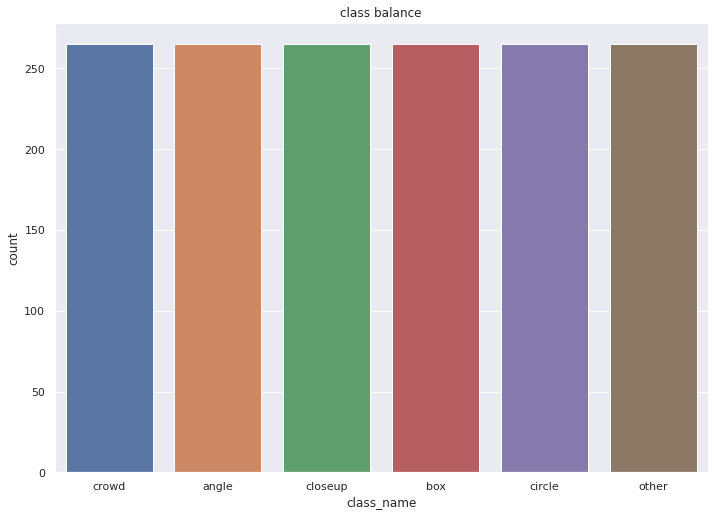

In [44]:
# class balance in train set plot
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.countplot(data=train_df, x="class_name");
title = "class balance"
plt.title(title);

**Data augmentation**

Since we have oversampled our dataset, image augmentation is need to smooth the similarity between the duplicated images

In [45]:
# create image generators using flow_from_directory
train_generator, validation_generator, test_generator = create_generators()

Found 1434 images belonging to 6 classes.
Found 156 images belonging to 6 classes.
Found 60 images belonging to 6 classes.


**Train**

Enlarged dataset, early stopping callback and adaptive learning rate 

In [46]:
# 
# adaptive learning rate scheduler
def scheduler(epoch, lr):
   if epoch == 55 or epoch == 100:
     return lr / 10
   return lr

def unfreeze_model(model):
  # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
  for layer in model.layers[-20:]:
      if not isinstance(layer, layers.BatchNormalization):
          layer.trainable = True

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
  return model

In [ ]:
# wandb train run
time_stamp = datetime.datetime.now(tz=timezone("Israel")).strftime("%d-%m-%Y-%H:%M:%S")
job_type = "Train"
train_wb_client = wandb.init(name="oversampling model train", project=wandb_project_name, group=f"oversampling model {time_stamp}", job_type=job_type)

# training parameters
lr = 0.0052 #@param {type:"slider", min:0.000001, max:0.2, step:0.0001}
epochs = 150 # @param {type: "slider", min:10, max:1000}
optimizer = keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.9)

# callbacks
wandb_cb = WandbCallback()
early_stopping_cb = EarlyStopping(monitor="val_loss", patience=25)
lr_scheduler_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)
  
# model = build_efficientnet_pretrained(len(class_list), dropout=0.5, is_trainable=False)
model = build_efficientnet(len(class_list), dropout=0.5)
# model = unfreeze_model(model)
model.compile(
      optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
      )
model.summary()

hist = model.fit(train_generator, validation_data=test_generator, epochs=epochs, callbacks=[wandb_cb, early_stopping_cb, lr_scheduler_cb])

accuracy,▁▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██▇███████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▂▄▇▇▅▂▅▇▆▆▆▇▇▆▇▇▇▇▆▇█▆▇▇▇▆█▇▇▇▇█████▆
val_loss,█▅▂▃▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.9728
best_epoch,33
best_val_loss,0.80125
epoch,53
loss,0.08433
val_accuracy,0.66667


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 6)                4057257   
                                                                 
Total params: 4,057,257
Trainable params: 4,015,234
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/150
90/90 [==============================] - 57s 538ms/step - loss: 2.9787 - accuracy: 0.3431 - val_loss: 40.4048 - val_accuracy: 0.1667 - lr: 0.0052
Epoch 2/150
90/90 [==============================] - 45s 504ms/step - loss: 1.4678 - accuracy: 0.4756 - val_loss: 34.7706 - val_accuracy: 0.1667 - lr: 0.0052
Epoch 3/150
90/90 [==============================] - 45s 504ms/step - loss: 1.1477 - accuracy: 0.5488 - val_loss: 7.5973 - v

**Evaluate**

In [48]:
# model evaluation
job_type = "Eval"
eval_wb_client = wandb.init(name=f"oversampling model eval", project=wandb_project_name,group=f"oversampling model {time_stamp}", job_type=job_type)

model_eval(model, eval_wb_client, overall=True, per_class=True)

accuracy,▁▂▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▂▄▅▅▇▅▇▅▄▇█▆▆▇▆▆▆▇▆█▇█▇█▇█▇▇▇█▇▇▇▇██
val_loss,█▄▃▂▃▁▁▂▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.9972
best_epoch,68
best_val_loss,0.8598
epoch,88
loss,0.01018
val_accuracy,0.8


4/4 [==============================] - 1s 235ms/step - loss: 1.3906 - accuracy: 0.8000
test loss, test acc: [1.3905518054962158, 0.800000011920929]
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        26
           1       0.64      0.92      0.75        25
           2       1.00      0.62      0.76        26
           3       0.69      0.83      0.75        24
           4       0.89      1.00      0.94        24
           5       0.90      0.67      0.77        27

    accuracy                           0.80       152
   macro avg       0.83      0.80      0.80       152
weighted avg       0.83      0.80      0.80       152

